In [ ]:
!pip install findspark
!pip install pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
from time import time
from dill.source import getfile

def init_spark(app_name: str):
  spark = SparkSession.builder.appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc
  
spark, sc = init_spark('proj2')
!unzip /content/Static\ data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 47.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=478c319cddaa551ba3dfe895be139c139a2f65384003165f6c363772389ff48c
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Archive:  /content/Static data.zip
  inflating: Static data/data.json   


In [ ]:
data = spark.read.json('/content/Static\ data/data.json')

In [ ]:
from pyspark.sql.types import StringType, ArrayType
from datetime import datetime
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.function import when


#Insight 1:
We wanted to study the schedule of each user during the day, so we extracted the movment of each user relative to the time of day to recieve the plot provided.

**Note:**

It seems most of the data was recorded during 1 day that is why the graph is describes a single day.

In [ ]:

# Converting time from timestamp to human readable time
# Creation_Time and Arrival_Time were close enough so choosing one will 
# suffice when exploring the data or training a model
data = spark.read.json('/content/Static\ data/data.json')
data = data.withColumn("Arrival_Time1", f.from_unixtime(f.col("Arrival_Time")/1000))
data = data.withColumn("Arrival_Date", f.split("Arrival_Time1", " ").getItem(0))
data = data.withColumn("Arrival_Date", f.split("Arrival_Time1", " ").getItem(1))
data = data.drop("Arrival_Time1")
data = data.drop("Creation_Time")

# We assume that certain activties are done in ceratin parts of the day
# so first we made a new column which represents the part of day the activity
# was logged, and then converted the column to dummy variables for our
# model to interpert


data = data.withColumn("p_day", when((6 <= f.hour("Arrival_Hour")) & (f.hour("Arrival_Hour") <= 12),"Morning")
                              .when((12 < f.hour("Arrival_Hour")) & (f.hour("Arrival_Hour") <= 19),"Noon")
                              .otherwise("Night"))
categories = ["Morning", "Noon", "Night"]

# exprs helps us extract dummy variables from the p_day column
exprs = [f.when(f.col("p_day") == category, 1).otherwise(0).alias(category) \
         for category in categories]
data = data.select('*', *exprs)

users = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]
user_movment = []
for user in users:
  user_movment.append(data.where(f"User == '{user}'")\
                      .select("Arrival_Hour", "gt").toPandas())



Converting to Panda's dataframe to visualize the conclusions **while not applying any meanigful transformations**

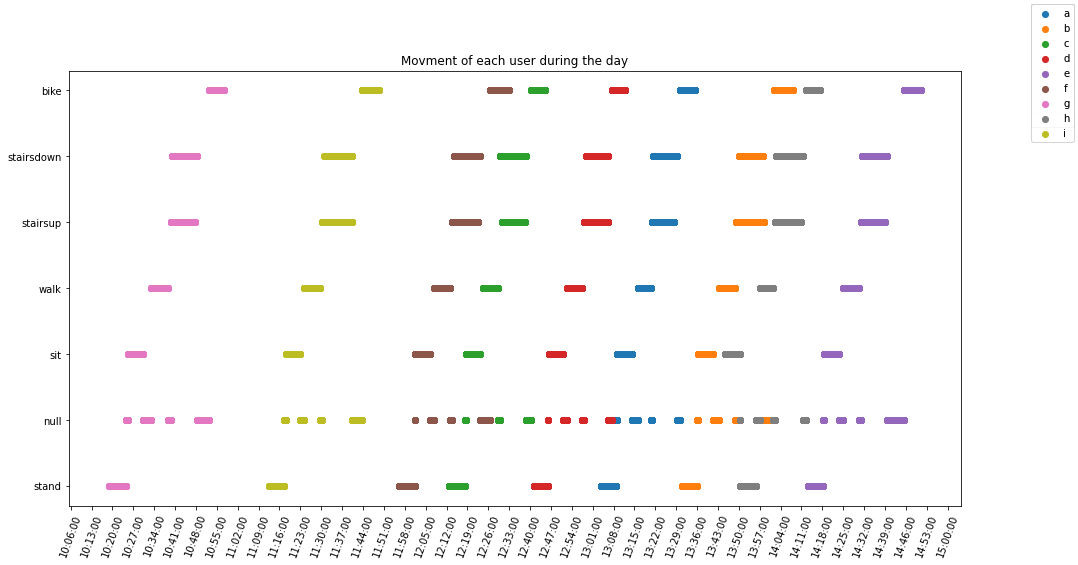

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker
import matplotlib.dates as md


acts = {'stand': 0, 'null': 1, 'sit': 2, 'walk': 3,
        'stairsup': 4, 'stairsdown': 5, 'bike': 6}

fig, ax = plt.subplots()
fig.set_size_inches((16,8))
for name, user in zip(users, user_movment):
  user["Arrival_Hour"] = pd.to_datetime(user["Arrival_Hour"])
  user["move"] = user["gt"].apply(lambda x: acts[x])

  ax.set_yticks(list(range(0,7)))
  ax.set_yticklabels(list(acts.keys()))
  plt.scatter(x=user["Arrival_Hour"], y=user["move"], label=name)
  plt.title("Movment of each user during the day")
  ax.xaxis.set_major_locator(md.MinuteLocator(interval = 7))
  ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
  plt.xticks(rotation=70)
  fig.legend()

From the plot we can deduce that almost every user has a specfic time of day where his data is being logged,we can see that parts of the day don't really provide enough to be able to distinguish, however, these parts of the day may help us narrow down which users are performing which activties

# Insight 2:
Here we are checking wether the device type has any effect on the activity being done by a given user

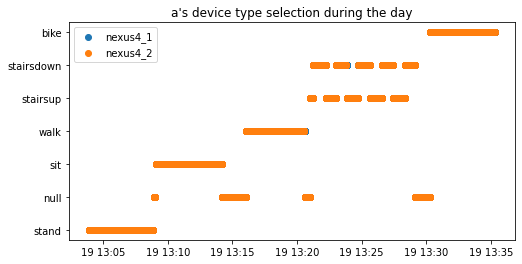

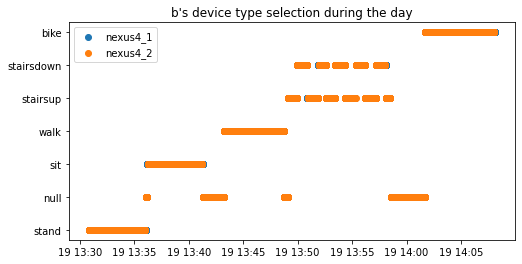

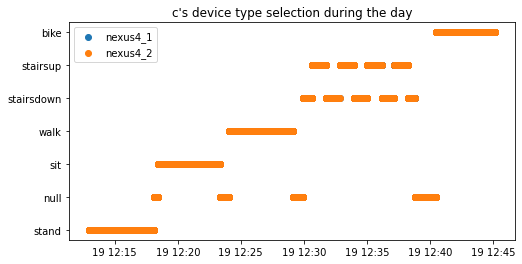

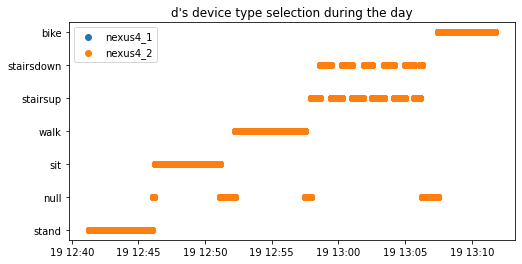

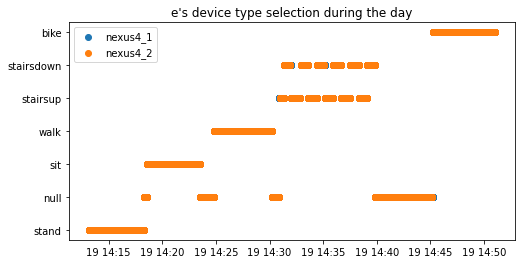

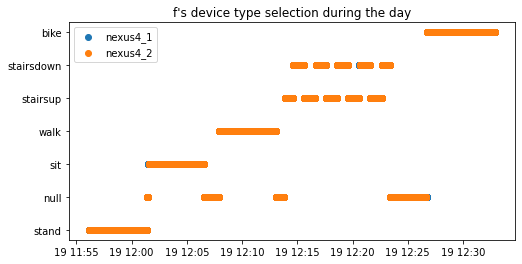

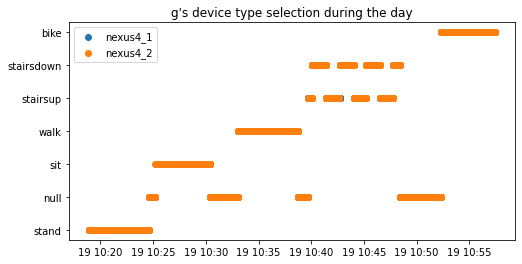

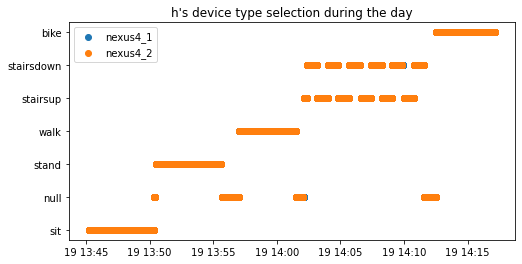

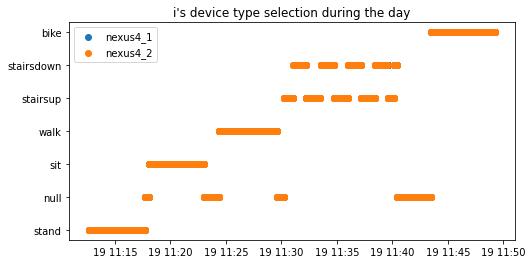

In [ ]:
for user in users:

  device = data.where(f"User == '{user}'").drop("Arrival_Time", "Index")\
    .select("Device", "gt", "Arrival_Hour").toPandas()
  fig, ax = plt.subplots()
  fig.set_size_inches((8,4))

  device["Arrival_Hour"] = pd.to_datetime(device["Arrival_Hour"])

  device_1 = device[device["Device"] == "nexus4_1"]
  plt.scatter(x=device_1["Arrival_Hour"], y=device_1["gt"], label="nexus4_1")
  device_2 = device[device["Device"] == "nexus4_2"]
  plt.scatter(x=device_2["Arrival_Hour"], y=device_2["gt"], label="nexus4_2")
  plt.title(f"{user}'s device type selection during the day")
  plt.legend()

We can see the graphs align almost perfectly, thus we can deduce that the device type isn't a factor

# Insight 3:
Intuitively we can associate certain activities with movment behavior, for example,

If the norm of the position (composition of x,y,z) is relatively low, then we can assume that the user isn't moving as much and so can be sitting or standing still.

On the other hand a relatively high norm can be attributed to climbing stairs up or down or biking...

We'll see if the data backs up our claims in the following segment

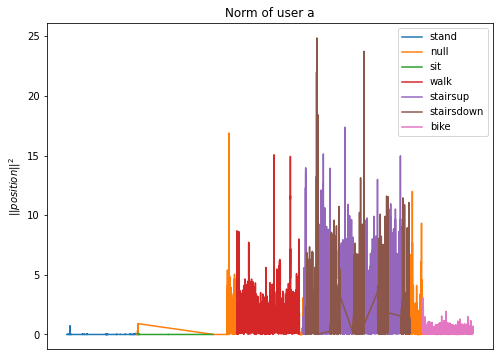

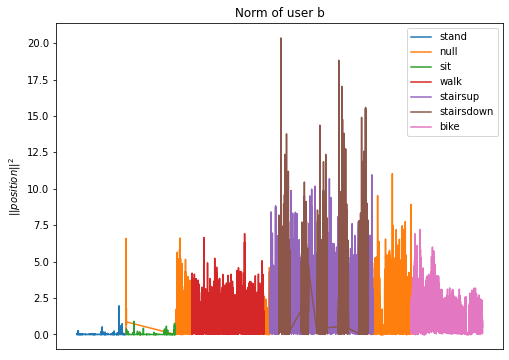

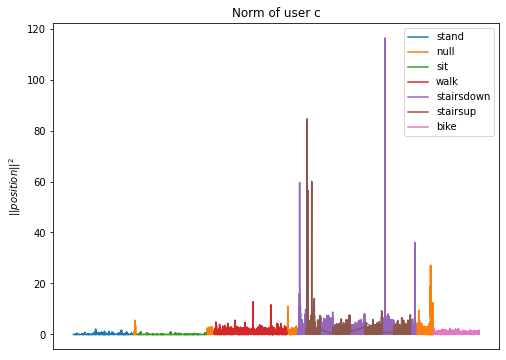

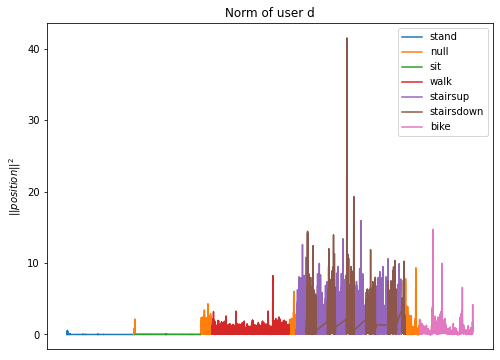

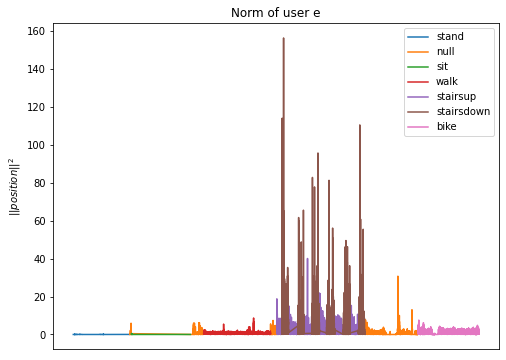

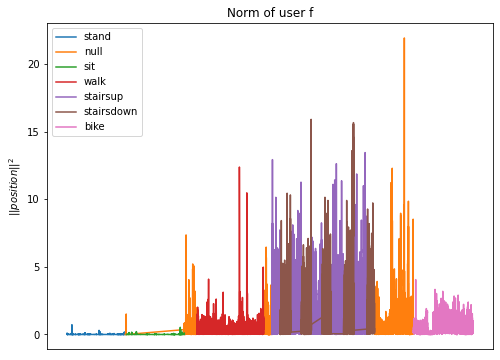

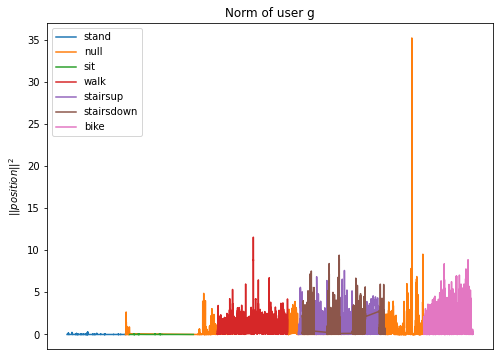

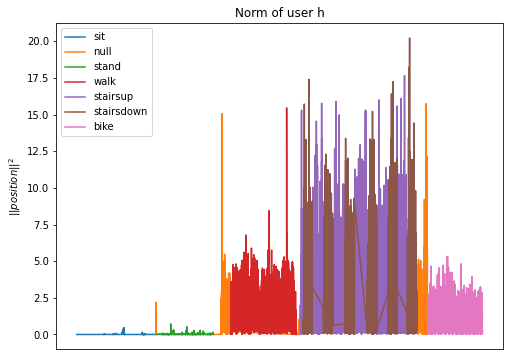

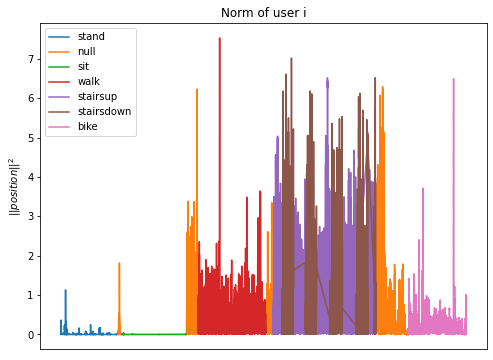

In [ ]:
from pyspark.sql.types import DoubleType

for user in users:
  delta = data.where(f"User == '{user}'").drop("Arrival_Date","Arrival_Hour","Model")\
        .orderBy("Arrival_Time").select("x", "y", "z", "gt")

  norm = f.udf(lambda x : sum([i ** 2 for i in x]), DoubleType())

  movs = delta.withColumn("Norm", norm(f.array("x", "y", "z"))).select("Norm", "gt").toPandas()
  import numpy as np

  from mpl_toolkits.axes_grid1.inset_locator import inset_axes
  from mpl_toolkits.axes_grid1.inset_locator import mark_inset

  fig, ax = plt.subplots()

  fig.set_size_inches((8,6))

  #movs["Norm"] = pd.to_numeric(movs["Norm"])
  #plt.plot(movs["Norm"])
  movs["Norm"] = pd.to_numeric(movs["Norm"])
  for state in list(movs["gt"].unique()):
    plt.plot(movs["Norm"][movs["gt"] == state], label=state)

  plt.title(f"Norm of user {user}")
  plt.ylabel('$||position||^2$')
  plt.xticks([])
  plt.legend()

**Note:**

The x axis resemebles time (according to the original query's structure), however, it's irrelevant during this analysis since we are studying the behavior of the norm with respect to a certain activity and that's why we hid the x axis.

From these plots we can see that the data supports the claims we made before, meaning 

In [2]:
!jupyter nbconvert --to html /content/part1.ipynb

[NbConvertApp] Converting notebook /content/part1.ipynb to html
[NbConvertApp] Writing 682193 bytes to /content/part1.html
